# Отток клиентов оператора связи

В этом проекте наша задача построить модель прогнозирования оттока клиента. Благодаря такой модели заказчик сможет своевременно предложить промокоды или специальные условия клиентам, склонным перестать пользоваться услугами, а также сэкономить маркетинговый бюджет не вовлекая в промоакции итак лояльных пользователей.

В нашем распоряжении 4 датасета:
- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Дата выгрузки данных из базы - 1 февраля 2020 года.

**Импорт библиотек**

In [ ]:
!pip install optuna
!pip install catboost
!pip install phik
!pip install -U scikit-learn
!pip install -U plotly
!pip install -U lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 2.1 MB/s 
     |████████████████████████████████| 81 kB 9.6 MB/s 
     |████████████████████████████████| 209 kB 53.9 MB/s 
     |████████████████████████████████| 78 kB 6.9 MB/s 
     |████████████████████████████████| 112 kB 51.2 MB/s 
     |████████████████████████████████| 49 kB 5.9 MB/s 
     |████████████████████████████████| 147 kB 45.8 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=b204947670ca3102e1e9a41340b6442a87f84674aedcb3708bf68e2b258de9a2
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 58 kB/s 
Looking in indexes: https://pypi.org/simple, https://u

In [ ]:
# python standard library
from collections import Counter
import re

# data analysis
import numpy as np
import pandas as pd
from scipy import stats
from phik.report import plot_correlation_matrix
import phik


# visualization
from lightgbm import plot_importance
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns

# machine learning
import catboost as cb
from catboost import Pool
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report
import optuna
from sklearn.model_selection import train_test_split, KFold, cross_validate

# misc
from tqdm import notebook
pd.set_option('display.max_columns', 500)
import warnings
warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING)

RS=120922

## Исследовательский анализ данных

Сперва загрузим все имеющиеся датасеты

In [ ]:
def camel_to_snake(df):
    '''
        Функция преобразует именя столбцов дататфрейма
        из верблюжьего регистра в змеиный.
        
        Параметры:
        ---------
        df:  pandas.core.frame.DataFrame
    '''
    for name in df.columns:
        new_name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
        new_name = re.sub('([a-z0-9])([A-Z])', r'\1_\2', name).lower()
        df = df.rename(columns={name:new_name})
    return df

In [ ]:
def resumetable(df):
    '''
        Функция рассчитывает основные описательные статистики
        для датафрейма.
        
        Параметры:
        ---------
        df:  pandas.core.frame.DataFrame
    '''
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['Most Frequent'] = df.mode().loc[0].values
    summary['Min'] = df.min().values
    summary['Max'] = df.max().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    return summary

In [ ]:
try:
    contracts = pd.read_csv('datasets/final_provider/contract.csv')
    personal = pd.read_csv('datasets/final_provider/personal.csv')
    internet = pd.read_csv('datasets/final_provider/internet.csv')
    phone = pd.read_csv('datasets/final_provider/phone.csv')
except:
    contracts = pd.read_csv('/datasets/final_provider/contract.csv')
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
    phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [ ]:
contracts = camel_to_snake(contracts)
personal = camel_to_snake(personal)
internet = camel_to_snake(internet)
phone = camel_to_snake(phone)

**Договоры**

In [ ]:
contracts.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [ ]:
resumetable(contracts)

Dataset Shape: (7043, 8)


,Name,dtypes,Missing,Uniques,Most Frequent,Min,Max,First Value,Second Value,Third Value
0,customer_id,object,0,7043,0002-ORFBO,0002-ORFBO,9995-HOTOH,7590-VHVEG,5575-GNVDE,3668-QPYBK
1,begin_date,object,0,77,2014-02-01,2013-10-01,2020-02-01,2020-01-01,2017-04-01,2019-10-01
2,end_date,object,0,5,No,2019-10-01 00:00:00,No,No,No,2019-12-01 00:00:00
3,type,object,0,3,Month-to-month,Month-to-month,Two year,Month-to-month,One year,Month-to-month
4,paperless_billing,object,0,2,Yes,No,Yes,Yes,No,Yes
5,payment_method,object,0,4,Electronic check,Bank transfer (automatic),Mailed check,Electronic check,Mailed check,Mailed check
6,monthly_charges,float64,0,1585,20.05,18.25,118.75,29.85,56.95,53.85
7,total_charges,object,0,6531,,,999.9,29.85,1889.5,108.15


**Клиенты**

In [ ]:
personal.head()

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [ ]:
resumetable(personal)

Dataset Shape: (7043, 5)


,Name,dtypes,Missing,Uniques,Most Frequent,Min,Max,First Value,Second Value,Third Value
0,customer_id,object,0,7043,0002-ORFBO,0002-ORFBO,9995-HOTOH,7590-VHVEG,5575-GNVDE,3668-QPYBK
1,gender,object,0,2,Male,Female,Male,Female,Male,Male
2,senior_citizen,int64,0,2,0.0,0,1,0,0,0
3,partner,object,0,2,No,No,Yes,Yes,No,No
4,dependents,object,0,2,No,No,Yes,No,No,No


**Интернет-услуги**

In [ ]:
internet.head()

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [ ]:
resumetable(internet)

Dataset Shape: (5517, 8)


,Name,dtypes,Missing,Uniques,Most Frequent,Min,Max,First Value,Second Value,Third Value
0,customer_id,object,0,5517,0002-ORFBO,0002-ORFBO,9995-HOTOH,7590-VHVEG,5575-GNVDE,3668-QPYBK
1,internet_service,object,0,2,Fiber optic,DSL,Fiber optic,DSL,DSL,DSL
2,online_security,object,0,2,No,No,Yes,No,Yes,Yes
3,online_backup,object,0,2,No,No,Yes,Yes,No,Yes
4,device_protection,object,0,2,No,No,Yes,No,Yes,No
5,tech_support,object,0,2,No,No,Yes,No,No,No
6,streaming_tv,object,0,2,No,No,Yes,No,No,No
7,streaming_movies,object,0,2,No,No,Yes,No,No,No


**Телефония**

In [ ]:
phone.shape

(6361, 2)

In [ ]:
phone.head()

,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Немного познакомившись с каждым датасетом по отдельности теперь объединим их в один для полноценного EDA.

Число записей в датасете с контрактами и с клиентами одинаково - с них и начнем.

In [ ]:
contracts.info(), personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null

(None, None)

In [ ]:
df = contracts.merge(personal, on='customer_id', how='inner')
df.shape

(7043, 12)

In [ ]:
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No


Следующие интернет-услуги и телефония: с ними будем объединяться используя left join, т.к. не все клиенты пользуются обеими услугами.

In [ ]:
df = df.merge(internet, on='customer_id', how='left')
df = df.merge(phone, on='customer_id', how='left')
df.shape

(7043, 20)

In [ ]:
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   object 
 14  online_backup      5517 non-null   object 
 15  device_protection  5517 non-null   object 
 16  tech_support       5517 

### Промежуточный вывод

**Что нам уже известно о данных?**
1. У нас 7043 клиентов;
2. Все даты выглядят как 1-ое число месяца;
3. Самый старый клиент с нами с октября 2013 года, самый новый с февраля 2020 года *(дата выгрузки данных)*;
4. По дате оттока у нас всего 5 типов значений: No и 4 даты;
5. В поле `total_charges` есть пропуски в виде пустой строки - **удалим их**;
6. Множество бинарных признаков представлены строковыми значениями Yes и No, их нужно закодировать числами;
7. Интернетом пользуются 5517 из всех клиентов, когда телефонией 6361 клиентов;
8. Большая часть пользователей интернета подключены по технологии оптоволокна и не пользуюься доп.услугами.

**На какие вопросы нужно ответить?**

1. Как выглядит распределение даты заключения контракта? Равномерное ли оно?
2. Как выглядит распределение ежемесячных трат клиентов и трат за всё время? Отличается ли оно для ушедших и активных клиентов?
3. Как распределены бинарные признаки: тип контракта, электронный чек, способ оплаты, пол, пенсионный возраст, наличие партнера, иждивенцев, технология интернета?
4. Какие дополнительные фичи мы можем создать из имеющихся данных?


*В процессе EDA нам понадобится проанализировать суммарные траты клиентов, поэтому сразу же удалим наблюдения с пустой строкой вместо трат и приведем поле к типу `float`.*

In [ ]:
print('Количество пропусков в поле total_charges =', df[df['total_charges'] == ' ']['total_charges'].count())
df = df[df['total_charges'] != ' ']
df['total_charges'] = df['total_charges'].astype('float')

Количество пропусков в поле total_charges = 11


Разметим клиентов по оттоку на 2 группы:
* если известна дата окончания контракта, значит клиент ушел;
* если неизвестна, значит активный клиент.

In [ ]:
df['churn'] = df['end_date'].where(df['end_date'] == 'No', 'Yes')

In [ ]:
df['churn'].value_counts(normalize=True)

No     0.734215
Yes    0.265785
Name: churn, dtype: float64

In [ ]:
px.histogram(df, x='begin_date', nbins=df['begin_date'].nunique(),
             title='Количество новых клиентов по месяцам', color='churn')

Мы видим распределение количества новых контрактов с клиентами по месяцам. Оранжевым цветом выделены клиенты, которых мы считаем ушедшими на 1 февраля 2020 года.

* У нас есть буквально 8 клиентов, заключивших договор раньше 2014 года - все они уже ушли;
* В среднем ежемесячно заключали новые договоры 50-100 клиентов;
* В феврале-марте 2014 года есть пик, свыше 350 новых клиентов - вероятно проводилась промоакция;
* С сентября 2019 цифры вышли на уровень, 200+ новых клиентов ежемесячно - возможно произошло какое-то крупное положительное изменение;
* С июня 2018 стал нарастать показатель оттока, возможно с этим и связана предполагаемая промоактивность по привлечению новых клиентов, начатая примерно в январе 2019;
* Среди клиентов, пришедших в январе-феврале 2020 года нет ушедших, поэтому они будут бесполезны для обучения - удалим их в предобработке.

In [ ]:
px.violin(df, y='monthly_charges', box=True, color='churn',
         title='Распределение ежемесячных трат клиентов')

In [ ]:
px.violin(df, y='total_charges', box=True, color='churn',
         title='Распределение суммарных трат клиентов')

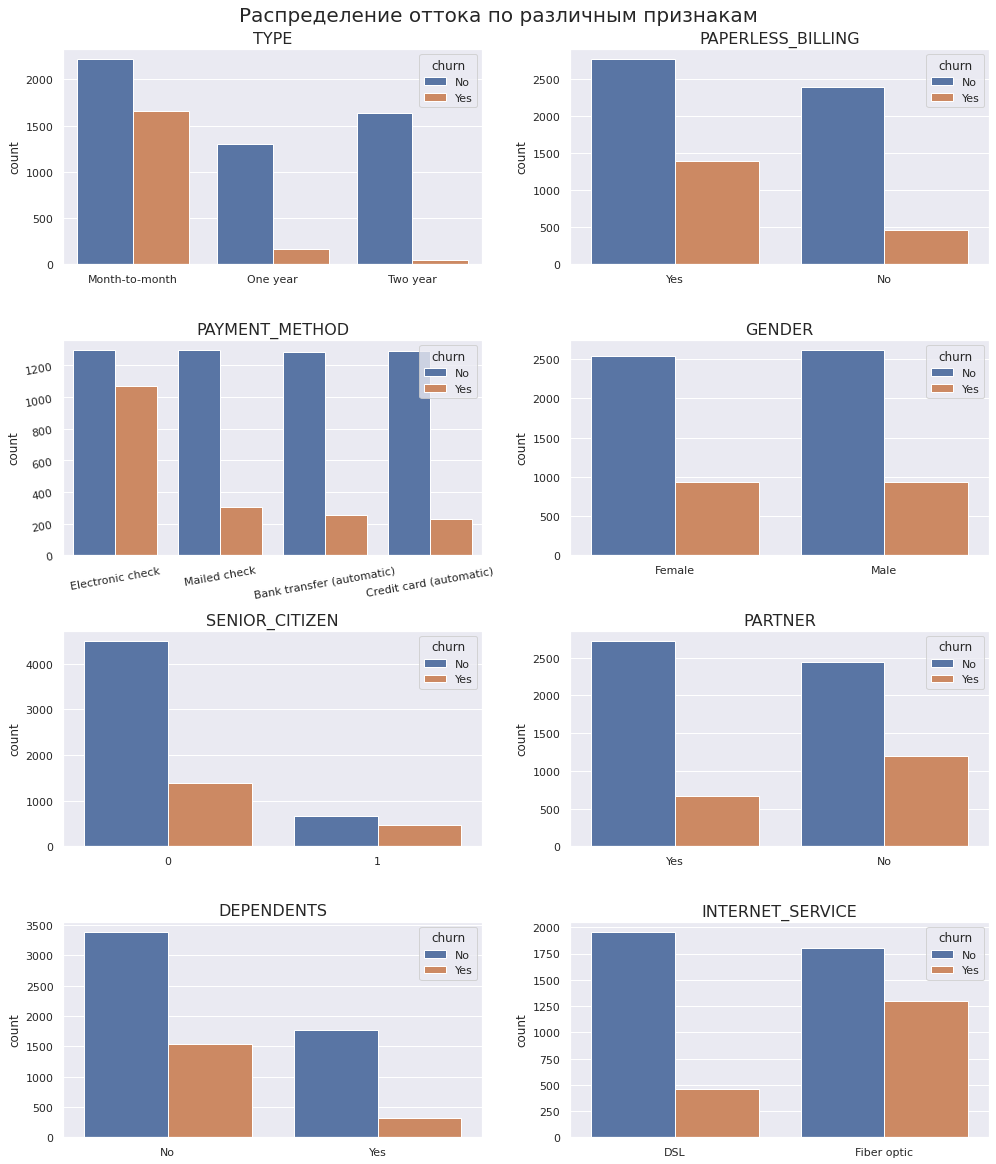

In [ ]:
sns.set(style="darkgrid")
fig, axs = plt.subplots(4, 2, figsize=(14, 16))
interested_columns = ['type', 'paperless_billing', 'payment_method',
                      'gender', 'senior_citizen', 'partner', 'dependents', 'internet_service']

for ax, col in zip(axs.flatten(), interested_columns):
    sns.countplot(data=df, x=col, hue='churn', ax=ax)
    ax.set_title(col.upper(), size=16)
    ax.set(xlabel=None)
    
axs[1, 0].tick_params(labelrotation=10)
plt.suptitle('Распределение оттока по различным признакам', fontsize=20, y=1.01)
fig.tight_layout()

### Вывод по EDA

* **Ежемесячные траты** лояльных клиентов имеют бимодальное распределение с пиками 21 (видимо минимальный тариф) и 81; 
    * медиана 64;
    * 50% клиентов находятся в диапазоне от 25 до 88;
* Ежемесячные траты ушедших клиентов заметно выше:
    * медиана 79;
    * 50% клиентов в диапазоне от 56 до 94
    
**Ушедшие клиенты платят больше**

* **Суммарные траты** менее показательны для разделения клиентов по оттоку:
    * Медиана трат лояльных клиентов 1683
    * Медиана трат ушедших клиентов 703 и бОльшая часть ушедших клиентов за время своей активности потратили меньше денег, чем лояльные пользователи. Однако среди ушедших клиентов есть "жирный хвост" с выбросами - это клиенты, которые платили очень много по сравнению с другими, возможно они были очень требовательными к услугам.
    
* **Тип подписки**: почти все ушедшие пользователи пользовались ежемесячной подпиской. Показатель лояльности клиента - оплата услуг сразу за 1-2 года;
* **Электронный чек**: по этому признаку пользователи разделились примерно поровну, однако среди получателей электронного чека показатель оттока выше более чем в 2 раза. Вероятно это связано с тем, что бумажную корреспонденцию получают и просматривают реже.
* **Способ оплаты**: в целом клиенты разделены на 4 категории примерно поровну, но отличный признак для разделения по оттоку - доля ушедших почти в 4 раза больше среди платящих с помощью электронного чека;
* **Пол**: не является признаком оттока, клиенты разделены поровну, как по полу так и по оттоку внутри своего пола;
* **Пенсионный возраст**: клиентов-пенсионеров в 7 раз меньше остальных клиентов, но среди них высокий показатель оттока. Возможно, пожилым людям трудно разобраться с тарифами и услугами и они не понимают, куда уходят деньги;
* **Наличие партнера**: среди наших клиентов примерно поровну людей с партнерами и одиноких, "семейные" клиенты в целом более лояльные, а вот среди холостых почти половина прекратили пользоваться услугами;
* **Наличие иждивенцев**: признак очень схож по значению с предыдущим, характеризует "семейность" человека, клиенты с детьми более лояльные;
* **Технология подключения интернета**: среди наших клиентов примерно поровну пользователей старой (DSL) и новой технологии (оптоволокно), однако почти 3/4 пользователей "оптики" остались недовольны качеством интернета и расторгли договор. Быть может у нас есть какие-то технические проблемы?


## Предобработка данных
Что сделаем?
1. Обработаем пропуски
2. Приведем столбцы к нужному типу
3. Создадим новые признаки: 
    1. "Время жизни" пользователя на момент выгрузки данных
    2. Какими услугами пользуется клиент: интернет, телефония, обе.
4. OneHotEncoding
5. Обработаем выбросы

### Обработка пропусков
* Пропуски у нас остались только в столбцах, детализирующих услуги, которые клиенты используют: интернет и телефонию.
* Эти пропуски не являются случайными, так как они присутствуют у тех клиентов, которые конкретную услугу не используют. Поэтому заполним их строками phone_only или inet_only соответственно.
* Но сперва проверим, есть ли наблюдения, в которых пропуски присутствуют как в части телефонии, так и в части интернета - вдруг есть клиенты, которые не пользуются ни одной услугой.

In [ ]:
df[df['multiple_lines'].isna() & df['internet_service'].isna()]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churn


In [ ]:
inet_only_mask = df['multiple_lines'].isna()
phone_only_mask = df['internet_service'].isna()

df.loc[inet_only_mask, 'multiple_lines'] = 'inet_only'
df.loc[phone_only_mask, internet.columns.drop('customer_id')] = 'phone_only'

Как мы помним из исследовательского анализа данных, у нас есть клиенты, которые пришли за месяц до выгрузки данных (т.е. в январе 2020 года) и среди них еще нет ушедших, так что удалим их из выборки.

In [ ]:
df.sample(10, random_state=RS)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churn
2421,3893-JRNFS,2014-06-01,No,Month-to-month,Yes,Bank transfer (automatic),39.90,2796.35,Male,0,No,No,DSL,No,No,Yes,No,No,Yes,inet_only,No
3356,2235-ZGKPT,2019-06-01,2019-10-01 00:00:00,Month-to-month,No,Mailed check,50.85,239.55,Female,0,Yes,Yes,DSL,No,No,No,No,No,No,Yes,Yes
1517,2924-KHUVI,2015-06-01,No,One year,Yes,Electronic check,100.55,5514.95,Male,0,Yes,No,Fiber optic,Yes,No,No,No,Yes,Yes,Yes,No
2335,3113-IWHLC,2019-09-01,No,Month-to-month,Yes,Mailed check,55.80,274.35,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,No
3452,8950-MTZNV,2020-01-01,No,Month-to-month,Yes,Mailed check,44.95,44.95,Male,0,No,No,DSL,No,No,No,No,No,No,No,No
3952,9861-PDSZP,2014-02-01,No,Two year,Yes,Credit card (automatic),108.05,7806.60,Female,0,No,No,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Yes,No
6699,3662-FXJFO,2015-08-01,No,Two year,Yes,Mailed check,20.50,1035.70,Female,0,No,No,phone_only,phone_only,phone_only,phone_only,phone_only,phone_only,phone_only,No,No
1741,0106-GHRQR,2018-10-01,No,Month-to-month,Yes,Bank transfer (automatic),71.40,1212.10,Male,0,No,No,DSL,No,Yes,Yes,No,No,Yes,Yes,No
5765,1265-XTECC,2014-02-01,2019-10-01 00:00:00,One year,Yes,Credit card (automatic),96.55,6581.90,Female,1,Yes,No,Fiber optic,Yes,Yes,No,No,No,Yes,Yes,Yes
6996,4174-LPGTI,2016-05-01,2019-10-01 00:00:00,One year,Yes,Bank transfer (automatic),66.50,2728.60,Female,0,Yes,Yes,DSL,No,Yes,No,Yes,No,Yes,No,Yes


In [ ]:
df = df[df['begin_date'] <= '2019-12-01'].reset_index(drop=True)
df.shape

(6799, 21)

### Приведение столбцов к нужному типу

* Столбец с датой 
* Категориальные фичи закодируем как 1/0, если бинарные и с помощью OHE, если категорий больше 2-х

In [ ]:
df['begin_date'] = pd.to_datetime(df['begin_date'], infer_datetime_format=True)

### Создание новых признаков

1. Время жизни пользователя от заключения контракта до 1 февраля 2020 года в месяцах.

In [ ]:
def lifetime_calculator(row):
    '''
    Функция рассчитывает время жизни для каждого пользователя.
    Возвращает число с плавающей точкой - количество месяцев.
        
    Параметры:
    ---------
    row:  одна строка из pandas.core.frame.DataFrame
    '''
    
    if row['end_date'] != 'No':
        row['lifetime'] = (pd.to_datetime(row['end_date']) 
                           - row['begin_date']) / np.timedelta64(1, "M")
    else:
        row['lifetime'] = (pd.to_datetime('2020-02-01') 
                           - row['begin_date']) / np.timedelta64(1, "M")
    return row

In [ ]:
df = df.apply(lifetime_calculator, axis=1)

Прежде чем удалять признак `end_date` проверим, правильно ли отработала функция на всех строках.

In [ ]:
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churn,lifetime
0,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,No,34.037660
1,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,Yes,2.004148
2,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,inet_only,No,45.044046
3,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,Yes,2.004148
4,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.50,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,Yes,8.049447


Время жизни клиента рассчитано верно, можем удалить столбец `end_date`.

In [ ]:
df = df.drop('end_date', axis=1)

2. Какими услугами пользуется: интернет, телефония или обе.

In [ ]:
# создаем лист с нашими условиями разделения на категории
# в виде булевых массивов
conditions = [
    (df['internet_service'].isna()),
    (df['multiple_lines'].isna()),
    (df['internet_service'].notna()) & (df['multiple_lines'].notna())
    ]
# строковые значения для новой фичи
values = ['phone', 'inet', 'both']

df['service'] = np.select(conditions, values)

df.head()

,customer_id,begin_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churn,lifetime,service
0,5575-GNVDE,2017-04-01,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,No,34.037660,both
1,3668-QPYBK,2019-10-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,Yes,2.004148,both
2,7795-CFOCW,2016-05-01,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,inet_only,No,45.044046,both
3,9237-HQITU,2019-09-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,Yes,2.004148,both
4,9305-CDSKC,2019-03-01,Month-to-month,Yes,Electronic check,99.65,820.50,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,Yes,8.049447,both


### Разделение на выборки

Перед кодированием категориальных признаков выполним разделение на выборки, чтобы энкодер обучить только на трейне, а применить и на трейне, и на тесте.

In [ ]:
le = LabelEncoder()
target = pd.Series(le.fit_transform(df['churn']), name='churn')

In [ ]:
target.head()

0    0
1    1
2    0
3    1
4    1
Name: churn, dtype: int64

In [ ]:
features = df.drop(['customer_id', 'begin_date', 'gender', 'churn'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25,
                                                    stratify=target, random_state=RS)

In [ ]:
X_train.shape, X_test.shape

((5099, 18), (1700, 18))

### OneHotEncoding
Для категориальных признаков, в т.ч. бинарных, выполним кодирование с помощью техники OHE. 

С целью избавления от мультиколлинеарности сразу будем выкидывать первый столбец из результата работы энкодера над одним признаком (аргумент `drop='first'`).

In [ ]:
ohe = OneHotEncoder(drop='first', sparse=False)

In [ ]:
# выделим категориальные фичи для кодировки
train_for_OHE = X_train.select_dtypes(include=['object'])
test_for_OHE = X_test.select_dtypes(include=['object'])

# на train'е энкодер обучается и сразу трансформирует данные
train_after_OHE = pd.DataFrame(
    data=ohe.fit_transform(train_for_OHE), 
    columns=ohe.get_feature_names_out(train_for_OHE.columns),
    index=train_for_OHE.index)
# на test'е энкодер только трансформирует данные
test_after_OHE = pd.DataFrame(
    data=ohe.transform(test_for_OHE), 
    columns=ohe.get_feature_names_out(test_for_OHE.columns),
    index=test_for_OHE.index)

In [ ]:
train_after_OHE.shape, test_after_OHE.shape

((5099, 24), (1700, 24))

Теперь собираем обратно обучающую и тестовую выборки, прошедшие через кодировку OHE.

In [ ]:
X_train = X_train.select_dtypes(exclude=['object']).join(train_after_OHE)
X_test = X_test.select_dtypes(exclude=['object']).join(test_after_OHE)

In [ ]:
X_train.shape, X_test.shape

((5099, 28), (1700, 28))

### Анализ мультиколлинеарности


Для оценки мультиколлинеарности конкатенируем фичи и таргет обучающей выборки и построим тепловую карту средствами Plotly. В результате у нас получится карта 29х29, котоорую мы сможем детально изучить в интерактивном режиме.

**Корреляция Phik**
* Включает в в себя как непрерывные признаки, так и категориальные;
* Учитывает нелинейные зависимости;
* В случае двумерного нормального распределения числовых входных признаков рассчитывается коэффициент корреляции Пирсона;
* Требует больших вычислительных ресурсов из-за вычисления интегралов внутри;
* Не указывает направление корреляции (положительная или отрицательная взаимосвязь).

Для визуализации матрицы воспользуемся тепловой картой из модуля Plotly.

При оценке корреляций также оценим их статистическую значимость, потому что большая корреляция может оказаться незначимой и наоборот.

Также отдельно взглянем на глобальную корреляцию целевого признака с остальными.


In [ ]:
df = df.drop('customer_id', axis=1)

In [ ]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()
phik_overview = df.phik_matrix(interval_cols=num_cols)

fig = go.Figure()
fig.add_trace(
    go.Heatmap(
        x=phik_overview.columns,
        y=phik_overview.index,
        z=np.array(phik_overview),
        text=phik_overview.values,
        texttemplate='%{text:.2f}'
    )
)
fig.update_layout(
    title=r"correlation $\phi_K$")
fig.show()

**Вывод по графику:**


---


* Целевой признак имеет корреляцию средней силы с временем жизни клиента и методом оплаты;
* Сильно (>0.7) коррелируют между собой:
    * дата заключения контракта и время жизни пользователя - *логично*;
    * дата заключения контракта и суммарные траты клиента - *логично*;
    * дата заключения контракта и `type`, способ оплаты - *вероятно более лояльные клиенты предпочитают платежи раз в 1-2 года помесячным*;
    * сумма ежемесячного платежа и наличие услуги нескольких телефонных линий - *вероятно эту опцию подключают клиенты, которые очень много пользуются услугами связи, отсюда и больше трат*;
    * сумма ежемесячного платежа и наличие опций к интернет-услуге - *больше опций - дороже тариф*;
    * сумма ежемесячного платежа и тип интернет-соединения - *очевидно, "оптика" дороже, чем DSL*;
    * наличие партнера и наличие иждивенцев - *логично, что у клиентов с партнером есть дети*;
    * тип интернет-соединения и услуга нескольких телефонных линий - *при подключенном интернете одна телефонная линия будет занята, поэтому нужно несколько линий для использования телефонии*;
    * все опции к интернет-услуге между собой - *возможно, если клиент готов подключить одну опцию, то склонен подключать и остальные доп.возможности*;
* признак пола клиента не коррелирует ни с одним другим признаком;
* также слабые и очень слабые корреляции с другими признаками имеют:
    * пенсионный возраст;
    * наличие иждивенцев;
    * электронный формат чека.

In [ ]:
significance_overview = df.significance_matrix(interval_cols=num_cols)

fig = go.Figure()
fig.add_trace(
    go.Heatmap(
        x=significance_overview.columns,
        y=significance_overview.index,
        z=np.array(significance_overview),
        text=significance_overview.values,
        zmin=-5, zmax=5,
        texttemplate='%{text:.2f}'
    )
)
fig.update_layout(title="Значимость коэффициентов корреляции",)
fig.show()

**Вывод по графику:**


---

* Все выводы по предыдущему графику подтвердились, их можно считать статистически значимыми.
* *За малым исключением - признаком пола, мы не можем достоверно утверждать, что отсутствие корреляции статистически значимо.*

In [ ]:
global_correlation, global_labels = df.global_phik(interval_cols=num_cols)

fig = go.Figure()
fig.add_trace(
    go.Heatmap(
        x=['churn'],
        y=global_labels,
        z=np.array(global_correlation),
        text=global_correlation,
        zmin=0, zmax=1,
        texttemplate='%{text:.2f}'
    )
)
fig.update_layout(title="Глобальная корреляция целевого признака с остальными")
fig.show()

**Вывод по графику:**


---

Все признаки имеют высокое значение корреляции с таргетом, кроме:
* пенсионного возраста;
* пола;
* метода оплаты;
* безбумажных чеков.

Значит, с помощью остальных переменных можно хорошо смоделировать целевой признак.

### Работа с выбросами

По результатам разведочного анализа данных у нас были выбросы только по столбцу `begin_date` - было много новых контрактов от февраля 2014, посмотрим отразились ли эти выбросы на признаке lifetime.


In [ ]:
px.histogram(df, x='lifetime', color='churn')

**Вывод по графику:**


---


Выбросы действительно сохранились - 658 клиентов являются клиентами уже более 70 месяцев. Однако, такое и правда может быть: люди ценят стабильность и постоянство, особенно если их всё устраивает. Так что наша модель должна знать об этой особенности.

## Моделирование

### Обучение модели

Сперва определимся с baseline, обучим 3 разных модели без тюнинга гиперпараметров. Посмотрим, какая из них даст лучший результат на кросс-валидации и её уже будем тюнить.

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=RS)

**Логистическая регрессия**

In [ ]:
lr = LogisticRegression(random_state=RS, class_weight='balanced')
scores = cross_validate(lr, X_train, y_train, cv=kf, scoring="roc_auc", n_jobs=-1)
np.mean(scores['test_score'])

0.8531417404070123

**LightGBM**

In [ ]:
booster_lgbm = LGBMClassifier(random_state=RS, class_weight='balanced')
scores = cross_validate(booster_lgbm, X_train, y_train, cv=kf, scoring="roc_auc", n_jobs=-1)
np.mean(scores['test_score'])

0.9069643532766186

**CatBoost**

In [ ]:
booster_cb = CatBoostClassifier(random_state=RS, eval_metric='AUC', silent=True)
scores = cross_validate(booster_cb, X_train, y_train, cv=kf, scoring="roc_auc", n_jobs=-1)
np.mean(scores['test_score'])

0.910767242335865

### Обучение с Optuna

Выполним обучение и fine-tuning для CatBoostClassifier.

In [ ]:
def optuna_search(obj_func, n_trials, study_name='unnamed'):
    '''
        Функция создает экземпляр optuna.study.Study c заданными параметрами
        оптимизации для модели. Эксперимент также сохраняется в локальную базу
        sqlite под уникальным названием, чтобы можно было продолжить 
        оптимизацию с места предыдущей остановки. 
        Возвращает экземпляр эксперимента после оптимизации.
        
        Параметры:
        ---------
        obj_func: функция, по которой происходит оптимизация
        n_trials: количество исследований в эксперименте
        study_name: имя эксперимента для сохранения в локальной БД
    '''
    study = optuna.create_study(direction='maximize',
                                study_name=study_name, 
                                storage="sqlite:///{}.db".format(study_name),
                                load_if_exists=True)
    study.optimize(obj_func, n_trials=n_trials, show_progress_bar=True)
    
    print("Number of completed trials: {}".format(len(study.trials)))
    print(f"\tBest score (ROC-AUC): {study.best_value:.5f}")
    print(f"\tBest params:")
    for key, value in study.best_params.items():
        print(f"\t\t{key}: {value}")
    return study

In [ ]:
def objective_lr(trial: optuna.Trial):
    logreg_c = trial.suggest_float('C', 1e-10, 1e10, log=True)
    tol = trial.suggest_float('tol', 1e-5, 1e-1, log=True)
    model = LogisticRegression(C=logreg_c)
    scores = cross_validate(model, X_train, y_train, cv=kf, scoring="roc_auc")
    return np.mean(scores['test_score'])

In [ ]:
def objective_lgbm(trial: optuna.Trial):
    '''
        Функция оптимизации модели LGBMClassifier. Внутри себя содержит 
        определенный диапазон для основных гиперпараметров бустинга.
        Возвращает значение метрики ROC-AUC на кросс-валидации.

        Параметры:
        ---------
        trial: экземпляр класса optuna.trial.Trial, исследование в эксперименте
    '''
    params = {       
        'objective': 'binary',
        'metric': 'auc',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2 ': trial.suggest_loguniform('lambda_l2 ', 1e-8, 10.0),
        "n_estimators": trial.suggest_int('n_estimators', 2000, 8000),
        'num_leaves': trial.suggest_int('num_leaves', 2, 512),
        "max_depth": trial.suggest_int("max_depth", 2, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 10000, step=100),
        "feature_fraction ": trial.suggest_float(
            "feature_fraction ", 0.2, 1.0, step=0.05),
        "bagging_fraction ": trial.suggest_float(
            "bagging_fraction ", 0.2, 1.0, step=0.05),
        'bagging_freq ': trial.suggest_int('bagging_freq ', 1, 7),
        'seed': RS,
        'class_weight': 'balanced'
    }
    model = LGBMClassifier(**params)
    scores = cross_validate(model, X_train, y_train, cv=kf, scoring="roc_auc", n_jobs=-1)
    return np.mean(scores['test_score'])

In [ ]:
def objective_cb(trial):
    '''
        Функция оптимизации модели CatBoostClassifier. Внутри себя содержит 
        определенный диапазон для основных гиперпараметров бустинга.
        Возвращает значение метрики ROC-AUC на валидации.

        Параметры:
        ---------
        trial: экземпляр класса optuna.trial.Trial, исследование в эксперименте
    '''

    X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train,
                                                      stratify=y_train, 
                                                      test_size=0.25, 
                                                      random_state=RS)
    params = {      
        'max_depth': trial.suggest_int('max_depth', 1, 8),
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 2000, 8000),
        'max_bin': trial.suggest_int('max_bin', 200, 400),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0001, 1.0, log = True),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        'random_seed': RS,
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'auto_class_weights': 'Balanced'
    }
    # Conditional Hyper-Parameters
    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    clf = CatBoostClassifier(**params)
    clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False, early_stopping_rounds=100)
    y_pred = clf.predict_proba(X_val)[:,1]
    roc_auc = roc_auc_score(y_val, y_pred)
    return roc_auc

Для удобства и простоты воспроизведения проекта - подгружаем предобученные исследования Оптуны

In [ ]:
!wget -c https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/bOmOVzOfdIE_fQ -O LogReg.db
!wget -c https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/PbOMR2ixtm5rrQ -O LGBM.db
!wget -c https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/BY-y7f8bMivitA -O cb.db

#### Логистическая регрессия

In [ ]:
lr_study = optuna_search(objective_lr, 1, 'LogReg')

  0%|          | 0/1 [00:00<?, ?it/s]

Number of completed trials: 302
	Best score (ROC-AUC): 0.85545
	Best params:
		C: 16312299.588410623
		tol: 4.579785969300106e-05


#### LightGBM

In [ ]:
lgbm_study = optuna_search(objective_lgbm, 1, 'LGBM')

  0%|          | 0/300 [00:00<?, ?it/s]

Number of completed trials: 300
	Best score (ROC-AUC): 0.92965
	Best params:
		bagging_fraction : 0.8500000000000001
		bagging_freq : 5
		feature_fraction : 0.2
		lambda_l1: 1.010205408781116
		lambda_l2 : 0.04083769386362178
		max_depth: 2
		min_data_in_leaf: 10
		n_estimators: 7366
		num_leaves: 476


#### CatBoost

In [ ]:
cb_study = optuna_search(objective_cb, 1, 'cb')

  0%|          | 0/1 [00:00<?, ?it/s]

Number of completed trials: 303
	Best score (ROC-AUC): 1.00000
	Best params:
		boosting_type: Ordered
		bootstrap_type: Bernoulli
		l2_leaf_reg: 0.14921606921112796
		learning_rate: 0.4491157815032428
		max_bin: 274
		max_depth: 5
		min_data_in_leaf: 289
		n_estimators: 4350
		subsample: 0.9660060528027548


### Выбор лучшей модели
Выбираем лучшую из оптимизированных с помощью оптуны моделей с помощью 5-фолдовой кросс-валидации на обучающей выборке.

In [ ]:
def cv_score(model) -> None:
    '''
        Функция принимает на вход экземпляр модели.
        Ничего не возвращает.
        Выводит на экран метрику ROC-AUC, рассчитанную для модели на кросс-валидации.

        Параметры:
        ---------
        model: экземпляр класса ML-модели.
    '''    
    scores = cross_validate(model, X_train, y_train, cv=kf, scoring="roc_auc", n_jobs=-1)
    score = np.mean(scores['test_score'])
    print('ROC-AUC on CV for {name} is {score}'.format(
        name=type(model).__name__, score=score))
    return None

In [ ]:
tuned_models_list = [
LogisticRegression(**lr_study.best_params, random_state=RS),
LGBMClassifier(**lgbm_study.best_params,
                              random_state=RS),
cb.CatBoostClassifier(**cb_study.best_params, 
                            silent=True,
                            random_seed=RS)]
for m in notebook.tqdm(tuned_models_list):
    cv_score(m)

  0%|          | 0/3 [00:00<?, ?it/s]

ROC-AUC on CV for LogisticRegression is 0.8548321764171023
ROC-AUC on CV for LGBMClassifier is 0.9297457513188627
ROC-AUC on CV for CatBoostClassifier is 0.9152199770296813


Обучим новый экземпляр модели с учетом подобранных гиперпараметров.

In [ ]:
best_model = tuned_models_list[1]
best_model.fit(X_train, y_train)

[LightGBM] [Warning] Unknown parameter: 5
[LightGBM] [Warning] Unknown parameter: 0.04083769386362178
[LightGBM] [Warning] Unknown parameter: 0.8500000000000001
[LightGBM] [Warning] Unknown parameter: 0.2
[LightGBM] [Warning] feature_fraction is set=, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=
[LightGBM] [Warning] bagging_fraction is set=, subsample=1.0 will be ignored. Current value: bagging_fraction=
[LightGBM] [Warning] lambda_l1 is set=1.010205408781116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.010205408781116
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_freq is set=, subsample_freq=0 will be ignored. Current value: bagging_freq=
[LightGBM] [Warning] lambda_l2 is set=, reg_lambda=0.0 will be ignored. Current value: lambda_l2=


LGBMClassifier(bagging_fraction =0.8500000000000001, bagging_freq =5,
               feature_fraction =0.2, lambda_l1=1.010205408781116,
               lambda_l2 =0.04083769386362178, max_depth=2, min_data_in_leaf=10,
               n_estimators=7366, num_leaves=476, random_state=120922)

### Визуализация результатов обучения

In [ ]:
optuna.visualization.plot_optimization_history(lgbm_study)

**Вывод по графику:** 


---


Функция ошибки за 150 испытаний подросла и устаканилась в районе 0.9, возможно проведя 1-2 тысячи испытаний мы бы получили еще небольшой рост.

In [ ]:
optuna.visualization.plot_slice(lgbm_study)

**Вывод по графику:** 


---


Оптуна довольно неплохо определяет оптимальные гиперпараметры:
* Фракция бэггинга нашла свое наилучшее значение в районе 0.8
* Фракция признаков в районе 0.2-0.3
* Максимальная глубина дерева = 2, так мы избегаем переобучения
* 

### Визуализация важности признаков

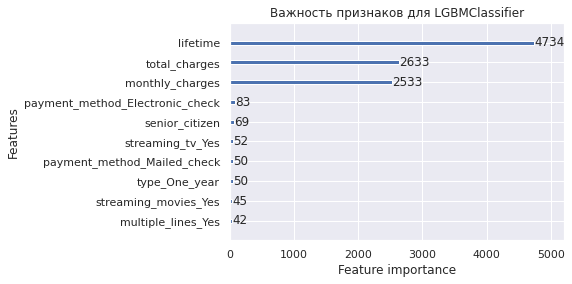

In [ ]:
plot_importance(best_model, 
                title='Важность признаков для LGBMClassifier',
                max_num_features=10);

**Вывод по графику:**


---


Наиболее важными признаками для классификации оказались:
* Время "жизни" как клиента компании
* Общая сумма трат абонента
* Сумма ежемесячных плат

## Оценка модели

Мы выполнили обучение и тюнинг модели, теперь пришло время оценить качество предсказаний на незнакомых данных - тестовая выборка.

In [ ]:
print('ROC-AUC лучшей модели на тестовой выборке =',
    round(roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1]), 5))

ROC-AUC лучшей модели на тестовой выборке = 0.94459


## Вывод


---



В процессе работы над проектом мы выполнили несколько важных этапов:
1. **Исследовательский анализ данных**

На этом этапе мы подробно познакомились с данными и составили портрет типичного ушедшего клиента:
* Ушедшие клиенты стабильно платят больше *ежемесячно* - возможно одной из причин их недовольства является недостаточная детализация расходов и избыточное количество доп.услуг;
* Большинство ушедших клиентов пользуются ежемесячным типом оплаты, вместо годовых планов, как лояльные клиенты;
* Показатели оттока также выше среди пользователей, получающий электронный чек;
* Также доля ушедших больше среди тех, кто платит с помощью электронного чека;
* Показатель оттока заметно выше среди пенсионеров, хоть этот признак и не показал значимого влияния с точки зрения статистики;
* Среди ушедших клиентов преобладают люди без парнеров и иждивенцев;
* Технология интернет-соединения оптоволокно дороже, но при этом видимо не всегда гарантирует хорошее качество услуги - количество ушедших в этой группе выше.

2. **Предобработка данных**

Мы привели столбцы к нужному типу и создали новые признаки на основе имеющихся, это признаки:
> * Время жизни пользователя, рассчитанное от даты заключения контракта до даты его расторжения или даты выгрузки данных;
> * Какими услугами пользуется клиента: интернет, телефония или обеими.

Разделили данные на обучающую и тестовую выборки.

Категориальные признаки закодировали с помощью техники OheHotEncoding, целевой признак с помощью LabelEncoding.

Провели анализ мультиколлинеарностьи с помощью коэффициента Phik, который включает в себя дополнительно анализ нелинейных взаимосвязей признаков и категориальные признаки.
> Выяснили:
> * Целевой признак имеет корреляцию средней силы с временем жизни клиента и методом оплаты;
> Сильно коррелируют между собой:
> * дата заключения контракта и type, способ оплаты;
> * сумма ежемесячного платежа и наличие услуги нескольких телефонных линий;
> * сумма ежемесячного платежа и наличие опций к интернет-услуге;
> * сумма ежемесячного платежа и тип интернет-соединения;
> * тип интернет-соединения и услуга нескольких телефонных линий;
> * все опции к интернет-услуге между собой;
> 
> Признак пола не коррелирует совсем с другими признаками, поэтому просто исключили его из датасета.


3. **Моделирование**



> Сперва мы обучили 3 модели без изменения стандартных гиперпараметров и оценили их с помощью кросс-валидации:
>
> * Логистическую регрессию;
> * Классификатор на основе бустинга LightGBM;
> * Классификатор на основе бустинга CatBoost.
На этом этапе лучше других себя показал CatBoost с метрикой ROC-AUC = 0.90696

> Следующим этапом мы подобрали наилучшие гиперпараметры для этих трёх моделей:
> * Подбор гиперпараметров провели с помощью библиотеки *Optuna* и выбрали лучшую из моделей на обучающей выборке с кросс-валидацией. 
> * В этот раз лучшим оказался бустинг LightGBM, его мы и выбрали. ROC-AUC = 0.92974

> Для лучшей модели провели оценку:
> * Качество работы модели "в бою" проверили на тестовой выборке и получили прекрасный результат: ROC-AUC модели на тестовой выборке = 0.94459;
> * Модель не переобучилась: значение метрики на кросс-валидации не отличается от значения на тестовой выборке.

# Отчет

## Исследовательский анализ данных
Первым пунктом плана было провести исследовательских анализ данных. Выполнено в полном объеме, выяснили следующую информацию о датасетах:
1. У нас 7043 клиентов;
2. Все даты несут информацию только о месяце начала/завершения контракта;
3. Самый старый клиент с нами с октября 2013 года, самый новый с февраля 2020 года *(дата выгрузки данных)*;
4. Незначительное количество строк с пропусами в поле `total_charges` удалены;
5. Интернетом пользуются 5517 из всех клиентов, телефонией 6361 клиентов;
6. Большая часть пользователей интернета подключены по технологии оптоволокна и не пользуюься доп.услугами.
7. В среднем ежемесячно заключали новые договоры 50-100 клиентов;
8. В феврале-марте 2014 года есть пик, свыше 350 новых клиентов - вероятно проводилась промоакция;
9. Составлен портрет типичного ушедшего клиента:
    * Ушедшие клиенты стабильно платят больше *ежемесячно*;
    * Большинство ушедших клиентов пользуются ежемесячным типом оплаты, вместо годовых планов, как лояльные клиенты;
    * Показатели оттока также выше среди пользователей, получающих электронный чек и оплачивающих с помощью электронного чека;
    * Среди ушедших клиентов преобладают люди без парнеров и иждивенцев;
    * Технология интернет-соединения оптоволокно дороже, но при этом видимо не всегда гарантирует хорошее качество услуги - количество ушедших в этой группе выше.

## Предобработка данных

1. Мы привели столбцы к нужному типу данных и создали новые признаки на основе имеющихся:
    * Время жизни клиента, рассчитанное от даты заключения контракта до даты его расторжения или даты выгрузки данных;
    * Какими услугами пользуется клиент: интернет, телефония или обеими.

2. Разделили данные на обучающую и тестовую выборки.

3. Категориальные признаки закодировали с помощью техники OheHotEncoding, целевой признак с помощью LabelEncoding.

4. Провели анализ мультиколлинеарности с помощью коэффициента Phik:
* Целевой признак имеет корреляцию средней силы с временем жизни клиента и методом оплаты;
* Выявили также несколько пар сильно коррелирующих между собой признаков и учли их при дальнейшем моделировании 
* Признак пола не коррелирует с другими признаками, поэтому просто исключили его из датасета.

5. По плану была еще обработка выбросов, но это не понадобилось, так как выбросы были только в количестве заключенных контрактов по датам, но это отражало реальную картину бизнеса в данных.

## Моделирование

В качестве оцениваемых классификаторов для текущей задачи проекта были выбраны 3 модели:
> * Логистическая регрессия;
> * Классификатор на основе бустинга LightGBM;
> * Классификатор на основе бустинга CatBoost.

**На первом этом этапе** все 3 модели были обучены без подбора гиперпараметров, но с помощью кросс-валидации на обучающей выборке. Лучше других себя показала модель CatBoost с метрикой ROC-AUC = 0.90696

**Вторым этапом** мы подобрали наилучшие гиперпараметры для этих трёх моделей с помощью библиотеки *Optuna* и выбрали лучшую из моделей на обучающей выборке с кросс-валидацией. 
* В этот раз лучшим оказался бустинг LightGBM, его мы и выбрали. ROC-AUC = 0.92974
* Набор признаков для обучения:
> * lifetime - время жизни клиента;
> * multiple_lines - несколько телефонных линий;
> * streaming_movies - стриминг фильмов;
> * streaming_TV - стриминг ТВ;
> * tech_support - расширенная тех.поддержка;
> * device_protection - дополнительная защита устройств;
> * online_backup - резервное копирование;
> * online_security - онлайн-антивирус;
> * internet_service - технология интернет соединения;
> * dependents - наличие иждивенцев;
> * partner - наличие партнера;
> * senior_citizen - является ли пенсионером;
> * total_charges - траты клиента за всё время;
> * monthly_charges - ежемесячные траты клиента;
> * payment_method - метод оплаты (эл.чек, банковский трансфер..);
> * paperless_billing - электронный чек вместо бумажного;
> * type - тип оплаты (помесячно, ежегодно...);
* По результатам обучения выявлены 3 наиболее важных для предсказания признака:
> * lifetime - время жизни клиента;
> * total_charges - траты клиента за всё время;
> * monthly_charges - ежемесячные траты клиента;

* Подобранные гиперпараметры для LightGBM:
        bagging_fraction : 0.8500000000000001
		bagging_freq : 5
		feature_fraction : 0.2
		lambda_l1: 1.010205408781116
		lambda_l2 : 0.04083769386362178
		max_depth: 2
		min_data_in_leaf: 10
		n_estimators: 7366
		num_leaves: 476

**Третьим этапом** провели оценку работы модели на неизвестных данных, на тестовой выборке:
> Получили прекрасный результат: ROC-AUC модели на тестовой выборке = 0.94459;
> * Модель не переобучилась: значение метрики на кросс-валидации не отличается от значения на тестовой выборке.